In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline

In [480]:
def is_vowel(ch):
    return ch.lower() in 'уеыаоэёяию'

def is_consonant(ch):
    return ch.lower() in 'йцкнгшщзхъфвпрлджчсмтьб'

def num_vowels(string):
    ans = 0
    for c in string:
        if is_vowel(c):
            ans += 1
    return ans

def is_caps(string):
    """
    RETURNS
    -------
    int : {0,1,2}
        0 - all chars are caps
        1 - only first char is caps
        2 - all chars are lower
    
    """
    if all(list(map(lambda x: x == x.upper(), string))):
        return 0
    elif string[0] == string[0].upper():
        return 1
    else:
        return 2

In [481]:
train = pd.read_csv("linear_train.txt", header=None, names=['x', 'y'])
train['x'] = list(map(lambda x: x.replace('ё', 'е'), train['x']))

# train['length'] = list(map(lambda x: len(x), train['x']))
train['vowels'] = list(map(lambda x: num_vowels(x), train['x']))
train['caps'] = list(map(lambda x: is_caps(x), train['x']))
train['last'] = list(map(lambda x: ord(x[-1]), train['x']))
train['first'] = list(map(lambda x: ord(x[0]), train['x']))


train_y = train['y']
train = train.drop(['y'], axis=1)

test = pd.read_csv("linear_test.txt", header=None, names=['x'])
test['vowels'] = list(map(lambda x: num_vowels(x), test['x']))
test['caps'] = list(map(lambda x: is_caps(x), test['x']))
test['last'] = list(map(lambda x: ord(x[-1]), test['x']))
test['first'] = list(map(lambda x: ord(x[0]), test['x']))

sample_submission = pd.read_csv("linear_ans_example.txt")

In [318]:
# clf = GradientBoostingClassifier()
clf = XGBClassifier()

train_x = train.drop(['x'], axis=1)
clf.fit(train_x, train_y)

accuracy_score(train_y, clf.predict(train_x))

0.89582675923004107

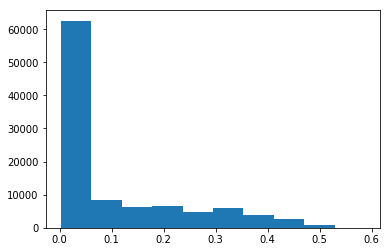

True

In [319]:
preds = clf.predict(train_x)
preds_prob = clf.predict_proba(train_x)

plt.hist(preds_prob[:, 1])
plt.show()
any(preds)

In [321]:
[(train.iloc[i]['x'], train_y[i]) for i in [i for i, x in enumerate(preds) if x == 1]]

[('Бабаев', 1),
 ('Бабер', 1),
 ('Бабинов', 1),
 ('Бабков', 1),
 ('Багио', 0),
 ('Багор', 0),
 ('Бадаев', 1),
 ('Бадан', 0),
 ('Бадер', 1),
 ('Бадминтон', 0),
 ('Бажанов', 1),
 ('Базаров', 1),
 ('Базин', 1),
 ('Базис', 0),
 ('Байес', 1),
 ('Байронов', 0),
 ('Бакиев', 1),
 ('Баклер', 1),
 ('Баков', 0),
 ('Бакстер', 0),
 ('Бакстон', 1),
 ('Балакирев', 1),
 ('Баландин', 1),
 ('Баланс', 0),
 ('Баланчин', 1),
 ('Балатон', 0),
 ('Балбес', 0),
 ('Балдахин', 0),
 ('Балкаров', 0),
 ('Балкон', 0),
 ('Баллов', 0),
 ('Баловство', 0),
 ('Балуев', 1),
 ('Бампер', 0),
 ('Бананов', 0),
 ('Банкир', 0),
 ('Банков', 0),
 ('Банкоматов', 0),
 ('Банкор', 0),
 ('Банн', 1),
 ('Баннер', 0),
 ('Банников', 1),
 ('Барабанов', 1),
 ('Бараков', 0),
 ('Баранов', 0),
 ('Баранов', 1),
 ('Барбар', 0),
 ('Барбур', 1),
 ('Барджер', 1),
 ('Барин', 0),
 ('Баркер', 1),
 ('Барклеев', 1),
 ('Бармен', 0),
 ('Бармин', 1),
 ('Барнс', 1),
 ('Баррето', 1),
 ('Баррингтон', 1),
 ('Барс', 0),
 ('Барс', 1),
 ('Барсуков', 1),
 ('Бартен

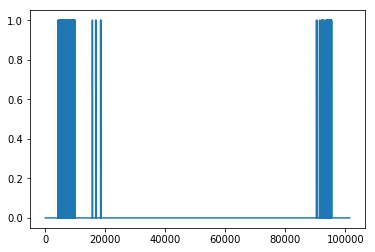

In [322]:
plt.plot(preds)

# Write an Answer

In [323]:
sample_submission['Answer'] = clf.predict_proba(test.drop(['x'], axis=1))[:, 1]

In [327]:
[(test.iloc[i]['x'], sample_submission.iloc[i]['Answer']) for i in [i for i, x in enumerate(sample_submission['Answer']) if x > 0.5]]

[('Баб', 0.5126273),
 ('Бабаков', 0.51590627),
 ('Бабаян', 0.51258528),
 ('Бабб', 0.5126273),
 ('Бабенко', 0.51258528),
 ('Бабешко', 0.51258528),
 ('Бабин', 0.52299863),
 ('Бабичев', 0.51590627),
 ('Бабкин', 0.52299863),
 ('Бабуин', 0.51258528),
 ('Бабур', 0.5050227),
 ('Бабурин', 0.51258528),
 ('Бабченко', 0.51258528),
 ('Бавыкин', 0.51258528),
 ('Багов', 0.50693578),
 ('Багров', 0.50693578),
 ('Багс', 0.56133568),
 ('Бадалов', 0.51590627),
 ('Баданов', 0.51590627),
 ('Баден', 0.52299863),
 ('Баджо', 0.52299863),
 ('Бадмаев', 0.51590627),
 ('Баев', 0.50693578),
 ('Баер', 0.5050227),
 ('Баженов', 0.51590627),
 ('Базанов', 0.51590627),
 ('Базар', 0.5050227),
 ('Базылев', 0.51590627),
 ('Байбаков', 0.51590627),
 ('Байбл', 0.52204055),
 ('Байдаков', 0.51590627),
 ('Байдуков', 0.51590627),
 ('Байер', 0.5050227),
 ('Байер', 0.5050227),
 ('Байерс', 0.5050227),
 ('Байкер', 0.5050227),
 ('Байкеров', 0.51590627),
 ('Байков', 0.50693578),
 ('Байрамов', 0.51590627),
 ('Байрнс', 0.56133568),
 ('Ба

In [328]:
sample_submission

,Id,Answer
0,0,0.385555
1,1,0.204118
2,2,0.399775
3,3,0.228955
4,4,0.385555
5,5,0.228625
6,6,0.457375
7,7,0.337508
8,8,0.337508
9,9,0.330046


In [329]:
sample_submission.to_csv("submission.csv", sep=',', index=False)

In [330]:
len(sample_submission)

188920

In [168]:
# for i in clf.predict(train_x):
#     print(i)

In [151]:
make_ngrams('Аарон', 2)

['аа', 'ар', 'ро', 'он']

In [260]:
ffff = ''.join(train['x'])
set(ffff.lower())

{' ',
 "'",
 '-',
 '.',
 '/',
 '2',
 '3',
 '4',
 '7',
 '«',
 '·',
 '»',
 'é',
 'ó',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ѐ',
 'ё',
 '’',
 '“',
 '”'}

In [332]:
len(ch_gram_alphabet)

961

In [334]:
ch_gram_alphabet.index('жэ')

215

In [241]:
tttt = np.zeros(10)

In [249]:
tttt[5] += 1

In [250]:
tttt

array([ 0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.])

In [362]:
def get_vector(ch_gram, gram_alphabet):
    ch_gram = ch_gram.lower()
    tmp = np.zeros(len(gram_alphabet))
    if ch_gram in gram_alphabet:
        tmp[gram_alphabet.index(ch_gram)] = 1
    return tmp
        
    
def string_to_vec(string):
    alphabet = ''.join([chr(i) for i in range(ord('а'), ord('я'))])
    ch_gram_alphabet = []

    for i in alphabet:
        for j in alphabet:
            ch_gram_alphabet.append(i + j)
            
    string = string.lower()
    grams = make_ngrams(string, 2)
    tmp_ans = np.zeros(len(ch_gram_alphabet))
    for gram in grams:
        tmp_ans += get_vector(gram, ch_gram_alphabet)
    return tmp_ans / len(grams)


def make_ngrams(string, n=2):
    string = string.lower()
    return [string[i:i+n] for i in range(len(string) - n + 1)]

In [364]:
alphabet = ''.join([chr(i) for i in range(ord('а'), ord('я'))])
ch_gram_alphabet = []

for i in alphabet:
    for j in alphabet:
        ch_gram_alphabet.append(i + j)

# ch_gram_alphabet

In [366]:
# string_to_vec('барабан')

In [370]:
mat = np.random.uniform(0, 1, len(ch_gram_alphabet))

In [374]:
np.dot(mat, string_to_vec('квартира'))

0.37516333715731004

In [377]:
test = pd.DataFrame()

In [445]:
test = pd.DataFrame(columns=[1,2,3,4])
test

,1,2,3,4


In [446]:
test = test.append(pd.DataFrame(data=[['kek', 2,2,2]], columns=test.columns.values))
test = test.append(pd.DataFrame(data=[['mkl', 1,20,3]], columns=test.columns.values))
test

,1,2,3,4
0,kek,2.0,2.0,2.0
0,mkl,1.0,20.0,3.0


In [447]:
new_train = pd.DataFrame(columns=np.concatenate((train.columns.values, np.arange(len(ch_gram_alphabet)))))
new_train

,x,vowels,caps,last,first,0,1,2,3,4,...,951,952,953,954,955,956,957,958,959,960


In [450]:
import tqdm

In [456]:
res = []

for i in tqdm.tqdm(range(len(train))):
    res.append(np.concatenate((train.iloc[i], string_to_vec(train.iloc[i]['x']))))


100%|██████████| 101408/101408 [01:44<00:00, 974.02it/s] 


In [467]:
new_train = pd.DataFrame(data=res, columns=np.concatenate((train.columns.values, np.arange(len(ch_gram_alphabet)))))
# new_train

In [496]:
%%time
clf = XGBClassifier(max_depth=20)
clf.fit(new_train.drop(['x'], axis=1), train_y)

CPU times: user 51min 40s, sys: 20.1 s, total: 52min
Wall time: 15min 1s


In [497]:
sum(train_y)/len(train_y)

0.10490296623540549

In [498]:
preds = clf.predict(new_train.drop(['x'], axis=1))

In [499]:
sum(preds)/len(preds)

0.069905727358788264

In [500]:
# it was 0.90675291890186183 with 0.87 on public leaderboard
accuracy_score(train_y, preds)

0.95879023351214898

In [482]:
test

,x,vowels,caps,last,first
0,Аалто,3,1,1086,1040
1,ААР,2,0,1056,1040
2,Аара,3,1,1072,1040
3,Ааре,3,1,1077,1040
4,Аарон,3,1,1085,1040
5,Аароне,4,1,1077,1040
6,Ааронов,4,1,1074,1040
7,Аароном,4,1,1084,1040
8,Аароном,4,1,1084,1040
9,Аарону,4,1,1091,1040


In [483]:
train

,x,vowels,caps,last,first
0,Аалтонен,4,1,1085,1040
1,Аар,2,1,1088,1040
2,Аарон,3,1,1085,1040
3,ААРОН,3,0,1053,1040
4,Аарона,4,1,1072,1040
5,Аарона,4,1,1072,1040
6,Аароне,4,1,1077,1040
7,Ааронов,4,1,1074,1040
8,Аахена,4,1,1072,1040
9,Абабков,3,1,1074,1040


In [484]:
new_test = pd.DataFrame(columns=np.concatenate((test.columns.values, np.arange(len(ch_gram_alphabet)))))
new_test

,x,vowels,caps,last,first,0,1,2,3,4,...,951,952,953,954,955,956,957,958,959,960


In [485]:
res_test = []

for i in tqdm.tqdm(range(len(test))):
    res_test.append(np.concatenate((test.iloc[i], string_to_vec(test.iloc[i]['x']))))

100%|██████████| 188920/188920 [03:02<00:00, 1085.76it/s]


In [488]:
new_test = pd.DataFrame(data=res_test, columns=np.concatenate((test.columns.values, np.arange(len(ch_gram_alphabet)))))
'kek'

'kek'

In [495]:
[(test.iloc[i]['x'], sample_submission.iloc[i]['Answer']) for i in [i for i, x in enumerate(sample_submission['Answer']) if x > 0.5]]

[('Абаев', 0.66012824),
 ('Абаева', 0.70196682),
 ('Абаевым', 0.8480584),
 ('Абакумова', 0.6250186),
 ('Абакумову', 0.51492387),
 ('Абакумовым', 0.77786678),
 ('Абаринов', 0.52259439),
 ('Аббасова', 0.67249894),
 ('Аббасову', 0.58515561),
 ('Абдуллаев', 0.69183254),
 ('Абдуллаева', 0.52556407),
 ('Абдуллаеву', 0.52887273),
 ('Абдуллаевым', 0.69222707),
 ('Абелева', 0.66355133),
 ('Абелевым', 0.82374549),
 ('Абердин', 0.61348879),
 ('Абердина', 0.54578722),
 ('Абердину', 0.53927827),
 ('Абзацев', 0.61924493),
 ('Абиев', 0.61924493),
 ('Абиевым', 0.82374549),
 ('Абрамова', 0.63661391),
 ('Абрамову', 0.50967354),
 ('Абрамовым', 0.72306675),
 ('Абрамс', 0.51192522),
 ('Абрамсом', 0.53128254),
 ('Абрамсон', 0.59437144),
 ('Абрамсоном', 0.67117774),
 ('Абрамсону', 0.67117774),
 ('Абросимова', 0.55639702),
 ('Аваковой', 0.59649396),
 ('Аввакумов', 0.64301473),
 ('Аввакумова', 0.59182674),
 ('Авериным', 0.63762593),
 ('Аверков', 0.57592237),
 ('Аверьянов', 0.52395779),
 ('Аверьянова', 0.637566

In [501]:
sample_submission['Answer'] = clf.predict_proba(new_test.drop(['x'], axis=1))[:, 1]

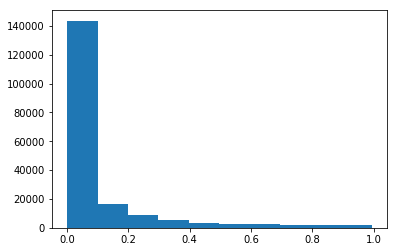

In [502]:
plt.hist(sample_submission['Answer'])
plt.show()

In [503]:
sample_submission.to_csv("submission.csv", sep=',', index=False)